# TI3130: Classification Lab &mdash; Solutions (variant B)
**Julián Urbano &mdash; January 2022**

In [1]:
import sys
import numpy as np
import pandas as pd
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

python 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0] 
numpy 1.22.0 
pandas 1.3.5 
plotnine 0.8.0 
statsmodels 0.13.1 
sklearn 1.0.2


For these exercises we will use the _Amsterdam Lite_ dataset and the _Heart_ dataset. Please refer to their HTML files for a description of the variables.

In [2]:
ams = pd.read_csv('amsterdam_lite.csv')
for col in ams.select_dtypes('object').columns:
    ams[col] = pd.Categorical(ams[col])

heart = pd.read_csv('heart.csv')
for col in heart.select_dtypes('object').columns:
    heart[col] = pd.Categorical(heart[col])

For these exercises we will use the evaluation metrics and cross-validation code we used in the tutorial:

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

def kfold_cv(X, y, k, H, cv_fun, random_state):
    """
    Do stratified k-fold cross-validation with a dataset, to check how a model behaves as a function
    of the values in H (eg. a hyperparameter such as tree depth, or polynomial degree).

    :param X: feature matrix.
    :param y: response column.
    :param k: number of folds.
    :param H: values of the hyperparameter to cross-validate.
    :param cv_fun: function of the form (X_train, y_train, X_valid, y_valid, h) to evaluate the model in one split,
        as a function of h. It must return a dictionary with metric score values.
    :param random_state: controls the pseudo random number generation for splitting the data.
    :return: a Pandas dataframe with metric scores along values in H.
    """
    kf = StratifiedKFold(n_splits = k, shuffle = True, random_state = random_state)
    pr = []  # to store global results

    # for each value h in H, do CV
    for h in H:
        scores = []  # to store the k results for this h
        # for each fold 1..K
        for train_index, valid_index in kf.split(X, y):
            # partition the data in training and validation
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # call cv_fun to train the model and compute performance
            fold_scores = cv_fun(X_train, y_train, X_valid, y_valid, h)
            scores.append(fold_scores)

        rowMeans = pd.DataFrame(scores).mean(axis = 0)  # average scores across folds
        pr.append(rowMeans)  # append to global results

    pr = pd.DataFrame(pr).assign(_h = H)
    return pr

**a) The first classifier in the tutorial notebook used a logistic model with a default threshold of 0.5. Function `predict` below implements a prediction function for the given `model`, test data `X_test` and response `vocabulary`. Implement this function such that it optimizes the recall of the second class, `2.high`.**

In [4]:
# sample data and model
X = ams.assign(y = ams['saf_catering'].cat.codes)
m = smf.glm('y ~ hou_value', X, family = sm.families.Binomial()).fit()

def predict(model, X_test, vocabulary):
    p = model.predict(X_test)
    # always predict 2.high
    threshold = 0 # optimize recall -> minimize FN -> don´t predict negatives
    p[p<threshold] = vocabulary[0]
    p[p>=threshold] = vocabulary[1]
    return p

# sample execution
predict(m, X, ams['saf_catering'].cat.categories)

0      2.high
1      2.high
2      2.high
3      2.high
4      2.high
        ...  
408    2.high
409    2.high
410    2.high
411    2.high
412    2.high
Length: 413, dtype: object

**b) Slide 38 shows an example of how complex models keep improving in the training set but not necessarily in a validation set because they eventually overfit. Use the _Heart_ dataset and decision trees to predict `ahd` with _all_ other features to produce a plot similar to the one in the slides via 10-fold cross-validation. You only need to plot accuracy in the training and validation sets. What number of leaves would you choose based on the results? You will need to use Pandas' [`get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) to encode categorical features.**

You would like to minimize the error form the 10-fold cv, which corresponds to k=6.

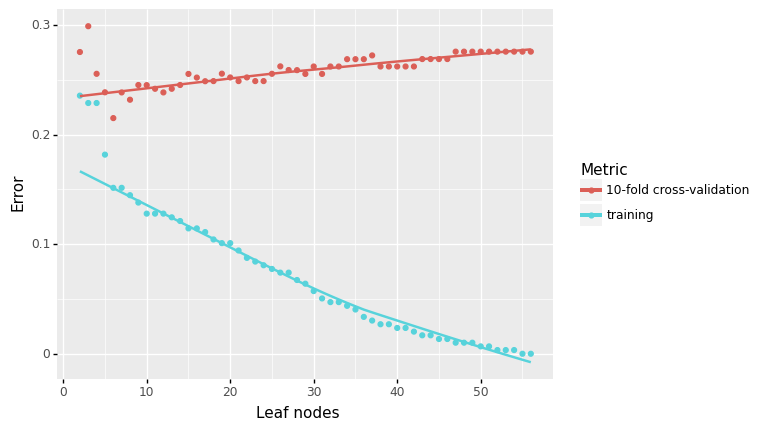

<ggplot: (8756001459544)>

In [5]:
from sklearn import tree
# sample data and model
y = heart['ahd'] # .cat.codes
X = pd.get_dummies(heart.loc[ : , heart.columns != 'ahd'])

# train
def cv_tree_leaf(X_train, y_train, X_valid, y_valid, h):
    # create classifier to prune to h leaf nodes
    # we set the random state here as well for full reproducibility
    c = tree.DecisionTreeClassifier(max_leaf_nodes = h, random_state = 54321)
    m = c.fit(X_train, y_train)  # fit the model with the training set
    p = m.predict(X_valid)  # predict on the validation set

    # compute and return evaluation metric scores
    return {'accuracy': accuracy_score(y_valid, p),
            'precision': precision_score(y_valid, p, average = 'macro', zero_division = 0),
            'recall': recall_score(y_valid, p, average = 'macro'),
            'f': f1_score(y_valid, p, average = 'macro'),
            'error': 1-accuracy_score(y_valid, p)}

def range_tree(X, y, H, cv_fun):
    pr = []  # to store global results

    # for each value h in H, do CV
    for h in H:
        # call cv_fun to train the model and compute performance
        fold_scores = cv_fun(X, y, X, y, h)
        pr.append(fold_scores)

    pr = pd.DataFrame(pr).assign(_h = H)
    return pr

train = range_tree(X, y, H = range(2, 57), cv_fun = cv_tree_leaf)
cv = kfold_cv(X, y, k = 10, H = range(2, 57), cv_fun = cv_tree_leaf, random_state = 12345)

pr = train.merge(cv, on='_h').loc[: ,['error_x', '_h', 'error_y']]
pr.columns = ['training', '_h', '10-fold cross-validation']
pr = pr.melt(id_vars = '_h', var_name = 'Metric')
ggplot(pr, aes('_h', 'value', color = 'Metric')) +\
    geom_point() +\
    geom_smooth(se = False) +\
    labs(x = 'Leaf nodes', y = 'Error')

**c) Use Scikit-learn's [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to build a model to predict `saf_nonneighbors` using all integer features in the dataset (you may have to increase the `max_iter` argument to something like `1000`). Produce a full classification report.**

In [6]:
from sklearn.linear_model import LogisticRegression
y = ams['saf_nonneighbors']
X = ams.select_dtypes('int')
clf = LogisticRegression(max_iter=1000).fit(X, y)
p = clf.predict(X)

print(classification_report(y, p))

              precision    recall  f1-score   support

       1.low       0.66      0.70      0.68       210
      2.high       0.67      0.64      0.65       203

    accuracy                           0.67       413
   macro avg       0.67      0.67      0.67       413
weighted avg       0.67      0.67      0.67       413



**d) Implement function `tree_ovo_fit` to fit a multi-class decision tree following a one-versus-one approach with individual binary decision trees.**

In [7]:
from sklearn import tree

# sample data
y = ams['spa_streets']
X = pd.get_dummies(ams.filter(regex = '^(fac_|inc_|saf_)'))

def tree_ovo_fit(X, y, random_state):
    models = []
    vocabulary = y.cat.categories
    
    # for every pair of classes cl1-cl2
        # filter out rows where the response is neither cl1 nor cl2
        # fit a model cl1-vs-cl2
        # store the model in models
    for i, cl1 in enumerate(vocabulary):
        for j in range(i + 1, len(vocabulary)):
            cl2 = vocabulary[j]
            mask = y.isin([cl1, cl2])

            y_filtered = y[mask]
            X_filtered = X[mask]
            clf = LogisticRegression(max_iter=1000, random_state=random_state).fit(X_filtered, y_filtered)
            models.append(clf)
            
    return {'vocabulary': vocabulary,
            'models': models}

# sample execution
m = tree_ovo_fit(X, y, random_state = 123)
m

{'vocabulary': Index(['1.low', '2.average', '3.high'], dtype='object'),
 'models': [LogisticRegression(max_iter=1000, random_state=123),
  LogisticRegression(max_iter=1000, random_state=123),
  LogisticRegression(max_iter=1000, random_state=123)]}

**e) Implement function `tree_ovo_predict` to predict from a model trained with `tree_ovo_fit`. The prediction should not be probabilistic (ie. it returns the predicted class). You will probably need a function to compute the mode (such as SciPy's [`mode`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html)), and a way to [flatten a list of lists](https://stackoverflow.com/a/953097/14674728).**

In [8]:
from scipy.stats import mode
from itertools import chain

# sample model
m = tree_ovo_fit(X, y, random_state = 123)

def tree_ovo_predict(model, X):
    # prepare an array with as many rows as X, and as many columns as individual models
    p = np.empty_like(model['vocabulary'], shape = [X.shape[0], len(model['models'])])
    
    # for every individual model
        # make a prediction and store it in p
    for i, ind_model in enumerate(model['models']):
        p[:, i] = ind_model.predict(X)
    
    # select the classes that got predicted most often and return them
    ovo_p = mode(p, axis=1)[0]
    return list(chain(*ovo_p))

p = tree_ovo_predict(m, X)
p

['2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '3.high',
 '2.average',
 '2.average',
 '2.average',
 '1.low',
 '2.average',
 '2.average',
 '1.low',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '1.low',
 '2.average',
 '2.average',
 '2.average',
 '1.low',
 '1.low',
 '1.low',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '1.low',
 '1.low',
 '2.average',
 '1.low',
 '2.average',
 '2.average',
 '2.average',
 '1.low',
 '2.average',
 '1.low',
 '2.average',
 '2.average',
 '1.low',
 '2.average',
 '2.average',
 '1.low',
 '2.average',
 '2.average',
 '1.low',
 '2.average',
 '2.average',
 '3.high',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '3.high',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '2.average',
 '3.high',
 '3.

**f) Fit an SVM model to predict `district` based on *all other* features in the dataset, and produce a full classification report with the training data. Is there any problem with this model, and if so, what is the cause? You don't need to tune hyperparameters, but you will need to use Pandas' [`get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) to encode categorical features.**

This model produces a 100% accuracy rate, which probably means that the model is overfitted on the training data. This makes sense as we do not have a test set disjoint from the training set.

              precision    recall  f1-score   support

   A Centrum       1.00      1.00      1.00        41
      E West       1.00      1.00      1.00        74
F Nieuw-West       1.00      1.00      1.00        67
      K Zuid       1.00      1.00      1.00        71
      M Oost       1.00      1.00      1.00        70
     N Noord       1.00      1.00      1.00        49
  T Zuidoost       1.00      1.00      1.00        41

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



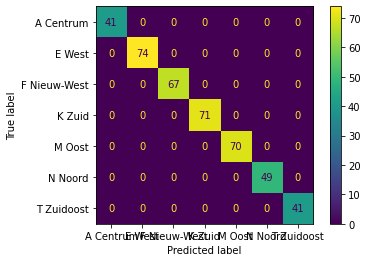

In [9]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# sample data
y = ams['district']
X = pd.get_dummies(ams.loc[ : , ams.columns != 'district'])

# "learn" how to scale from the training data
scaler = StandardScaler().fit(X)
# scale the feature matrix X and turn into a Pandas dataframe
X_prime = scaler.transform(X)
X_prime = pd.DataFrame.from_records(X_prime, columns = X.columns)

# train
c = SVC()
m = c.fit(X_prime, y)
p = m.predict(X_prime)

print(classification_report(y, p))
ConfusionMatrixDisplay.from_predictions(y, p, labels = y.cat.categories)

**g) Use 5-fold cross-validation to plot how the F-score is affected by `max_features` when building random forests to predict `ahd` based on _all_ other features in the _Heart_ dataset. Compare with the performance of a decision tree and a bagging model, also doing 5-fold cross-validation. Use 50 trees for random forests and bagging.**

   accuracy  precision    recall         f     error  _h
0  0.791525   0.790672  0.789269  0.789716  0.208475   0


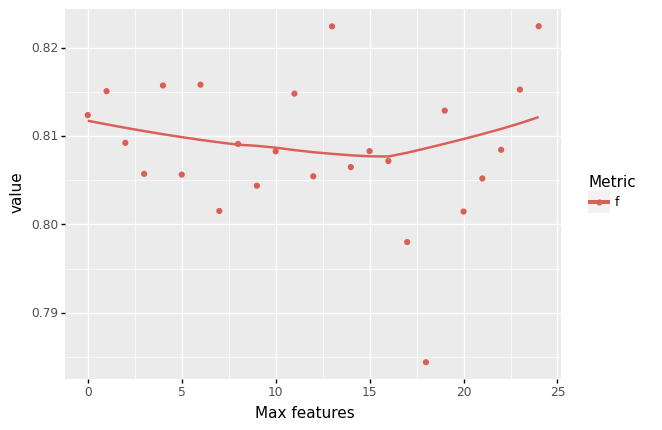

<ggplot: (8756001049329)>

In [10]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

def cv_random_forest(X_train, y_train, X_valid, y_valid, h):
    c = RandomForestClassifier(n_estimators = 50, max_features = 3)
    m = c.fit(X_train, y_train)  # fit the model with the training set
    p = m.predict(X_valid)  # predict on the validation set

    return {'accuracy': accuracy_score(y_valid, p),
            'precision': precision_score(y_valid, p, average = 'macro', zero_division = 0),
            'recall': recall_score(y_valid, p, average = 'macro'),
            'f': f1_score(y_valid, p, average = 'macro'),
            'error': 1-accuracy_score(y_valid, p)}

def cv_bagging(X_train, y_train, X_valid, y_valid, h):
    c = BaggingClassifier(n_estimators = 50)
    m = c.fit(X_train, y_train)  # fit the model with the training set
    p = m.predict(X_valid)  # predict on the validation set

    return {'accuracy': accuracy_score(y_valid, p),
            'precision': precision_score(y_valid, p, average = 'macro', zero_division = 0),
            'recall': recall_score(y_valid, p, average = 'macro'),
            'f': f1_score(y_valid, p, average = 'macro'),
            'error': 1-accuracy_score(y_valid, p)}


# sample data and model
y = heart['ahd'] # .cat.codes
X = pd.get_dummies(heart.loc[ : , heart.columns != 'ahd'])

# print(kfold_cv(X, y, k = 5, H = range(2,10), cv_fun = cv_tree_leaf, random_state = 12345))
# print(kfold_cv(X, y, k = 5, H = range(X.shape[1]), cv_fun = cv_random_forest, random_state = 12345))
print(kfold_cv(X, y, k = 5, H = range(1), cv_fun = cv_bagging, random_state = 12345))


pr = kfold_cv(X, y, k = 5, H = range(X.shape[1]), cv_fun = cv_random_forest, random_state = 12345)
pr = pr.loc[:, ['f', '_h']]
pr = pr.melt(id_vars = '_h', var_name = 'Metric')
ggplot(pr, aes('_h', 'value', color = 'Metric')) +\
    geom_point() +\
    geom_smooth(se = False) +\
    labs(x = 'Max features')

**h) The tutorial notebook built a multinomial model to predict `spa_streets` based on some features and their interactions, but the model had clear issues of class imbalance whereby the majority class `2.average` dominated the learning process. The resulting macro-averaged F-score was indeed low at 0.39. Try solving this issue by fitting the same model on a new dataset where the minority classes `1.low` and `3.high` are oversampled to contain the same number of instances as the majority class. Compare the model with the one in the tutorial using the original dataset. Does the new model improve in terms of imbalance? Why? You can use Pandas' [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.sample.html) to oversample instances.**

The model does not seem to be biased towards `2.average` anymore. For instance, the f-score has improved. The dataset has been oversampled towards a more balanced dataset, meaning that there is no majority class to be biased towards.

Optimization terminated successfully.
         Current function value: 0.864408
         Iterations 7
              precision    recall  f1-score   support

       1.low       0.64      0.69      0.67       240
   2.average       0.59      0.31      0.41       240
      3.high       0.61      0.85      0.71       240

    accuracy                           0.62       720
   macro avg       0.61      0.62      0.59       720
weighted avg       0.61      0.62      0.59       720



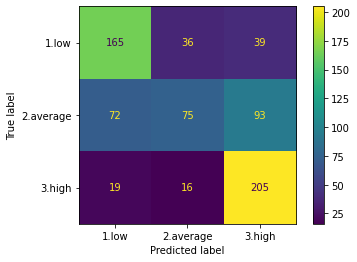

In [11]:
n = ams[ams['spa_streets'] == mode(ams['spa_streets'])[0][0]].shape[0]
amss = ams.groupby('spa_streets').sample(n, replace=True, random_state=12345)

amss['y'] = amss['spa_streets'].cat.codes

m = smf.mnlogit('y ~ (hou_corporation + hou_occupant + hou_other + hou_value)**2 + inc_income + inc_gini', amss).fit()

p = m.predict()
p = amss['spa_streets'].cat.categories[np.argmax(p, axis = 1)]

print(classification_report(amss['spa_streets'], p))
ConfusionMatrixDisplay.from_predictions(amss['spa_streets'], p, labels = amss['spa_streets'].cat.categories)

**i) Create an _unambiguous_ and _nontrivial_ question, and its corresponding solution, as if you were writing the set of exercises for the _Classification_ lab. The question must cover at least 3 of the following aspects:**

- **Logistic or Multinomial regression for classification**
- **Decision trees, bagging or random forests**
- **Support Vector Machines**
- **Model evaluation**
- **Choice of hyperparameters via cross-validation**
- **An open-ended question to explain some behavior**

**Please make it explicit which 3 of these aspects your question covers. You can use any of the datasets available on Brightspace.**